In [8]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize

from ipywidgets import widgets
from IPython.display import display

import numpy as np
import torch

from torch.utils.data import TensorDataset, DataLoader
import pytorch_lightning as pl

import glob

# Test 1: is it in fact convex?

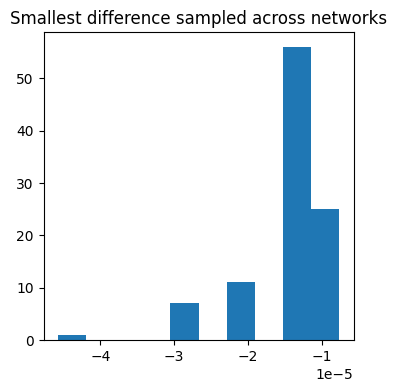

In [17]:
%run icnn.py

minDiffs = []
for i in range(100):
    model = BasicICNN()
    xtest = 10*torch.randn(1000, 2, 2)
    alphas = torch.rand(1000)

    diffs = (alphas[:,None]*model.forward(xtest[:,:,0]) + (1-alphas[:,None])*model.forward(xtest[:,:,1]) 
                - model.forward( alphas[:,None] * xtest[:,:,0] + (1-alphas[:,None]) * xtest[:,:,1] ) )
    minDiffs.append(diffs.min().detach())

figsize(4,4)
plt.title('Smallest difference sampled across networks')
plt.hist(minDiffs);


Here we see that there are some very slight deviations from convexity caused by the outputs being too close to linear. I'm not worried about this level of deviation

# Test 2: Learning

Training a simple 3 layer network, with early stopping, on a simple objective produces pretty good results. The network is able to be trained.

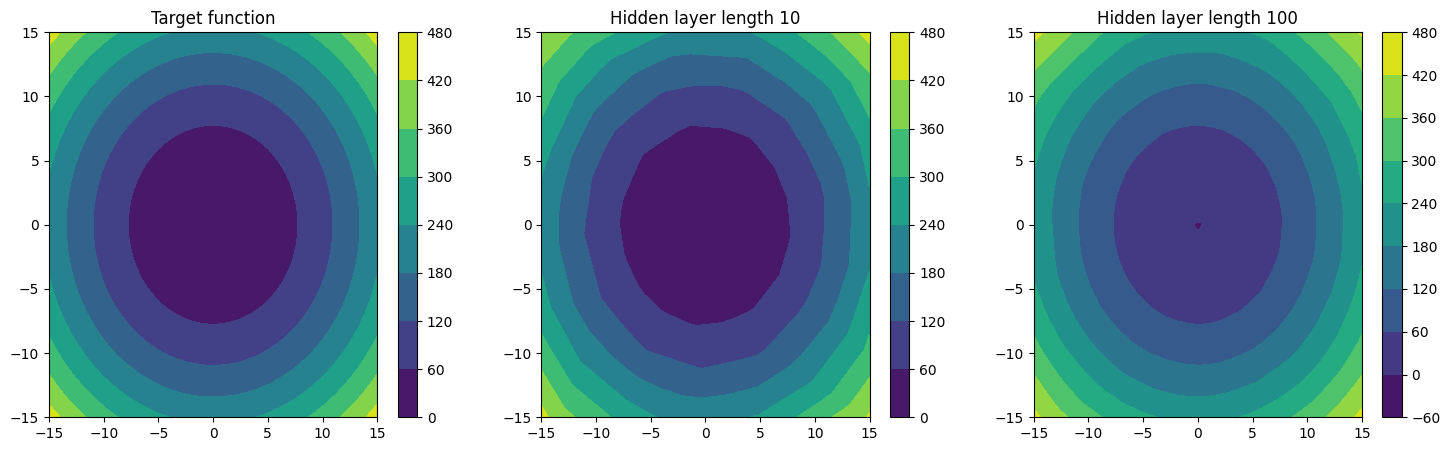

In [24]:
# 10 dim model
smallCheckpoint = glob.glob('lightning_logs/simpleQuadratic/*')[0]
smallModel = BasicICNN.load_from_checkpoint(smallCheckpoint)

# 100 dim model
largeCheckpoint = glob.glob('lightning_logs/simpleQuadratic_largeLatentDim/*')[1]
largeModel = BasicICNN.load_from_checkpoint(largeCheckpoint)


p1 = np.linspace(-15, 15, 1001)
p2 = np.linspace(-15, 15, 1001)

P1, P2 = np.meshgrid(p1, p2)

figsize(18,5)
plt.subplots(1,3)
plt.subplot(1,3,1)
plt.contourf(P1, P2, P1**2 + P2**2)
plt.xlim([-15,15])
plt.ylim([-15,15])
plt.title('Target function')
plt.colorbar()

plt.subplot(1,3,2)
testx = torch.tensor( np.stack([P1, P2]).reshape( 2, 1001*1001).T, dtype=torch.float32)
testy = smallModel.forward(testx)
plt.contourf( P1, P2, testy.detach().numpy().reshape(1001, 1001))
plt.title('Hidden layer length 10')
plt.colorbar()

plt.subplot(1,3,3)
testx = torch.tensor( np.stack([P1, P2]).reshape( 2, 1001*1001).T, dtype=torch.float32)
testy = largeModel.forward(testx)
plt.contourf( P1, P2, testy.detach().numpy().reshape(1001, 1001))
plt.title('Hidden layer length 100')
plt.colorbar()